<a name="top"></a><img src="source/SpinalHDL.png" alt="SpinalHDL based on Scala" style="width:320px;" />

运行SpinalHDL代码之前，务必加载SpinalHDL的库 
（**注**：*第一次运行时需要下载库，可能会有点慢，请耐心等待*）

In [ ]:
val path = System.getProperty("user.dir") + "/source/load-spinal.sc"
interp.load.module(ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path)))

## 总线
### apb

In [ ]:
import spinal.lib.bus.amba3.apb._
import spinal.lib.bus.misc._

class Top extends Component{
    val apb = slave(Apb3(Apb3Config(5,32,2)))
    val slv = Apb3SlaveFactory(apb,1)   
    //val regfile = Vec(Reg(Bits(32 bits)),32)
    val regfile = Mem(Bits(32 bits),32)
    when(slv.doRead){
        apb.PRDATA := regfile(slv.readAddress).allowPruning()
    }
    when(slv.doWrite){
        regfile(slv.writeAddress) := apb.PWDATA
    }
}

showRtl(new Top)

寄存器读写

In [ ]:

class Top extends Component{
    val apb = slave(Apb3(Apb3Config(8,32,2)))
    val slv = Apb3SlaveFactory(apb,1)  
    val regs = Vec(Reg(UInt(32 bits)) init 0 ,8)
    val  k = Reg(UInt(8 bits)) init 0
    val  f = Reg(UInt(4 bits)) init 0
    val  c = Reg(UInt(2 bits)) init 0

 slv.readAndWrite(regs(0),address=0)
 slv.write(k,address= 4,bitOffset=0)    
 slv.write(f,address= 4,bitOffset=8)   
 slv.write(c,address= 4,bitOffset=12)
 slv.read (c##f##k,address= 4)
 slv.readAndWrite(regs(1),address= 8 )
 slv.readAndWrite(regs(2),address= 12 )
 slv.readAndWrite(regs(3),address= 16 )
//slv.driveAndRead(regs(1),address=4)
//slv.write(regs(2),address=8)
//slv.readAndWrite(regs(3),address=12)
//slv.onRead( address=16)(Reg(4) :=0 )
//slv.onWrite( address=20)(Reg(4) :=0xff)   
//val a = slv.isWriting( address=24)   
//val b = slv.isReading( address=28)  
}

showRtl(new Top)

In [ ]:
class Top extends Component{
    val apb = slave(Apb3(Apb3Config(8,32,2)))
    val slv = Apb3SlaveFactory(apb,1)  
    val regs = Vec(Reg(UInt(32 bits)) init 0 ,8)
    val a,b,c = Reg(UInt(10 bits)) init 0 
    val clc = in Bool()
    val en2,en3= RegInit(False)
     
    //slv.write(address = 0,(0,a),(10,b),(20,c))
    //slv.read(address = 0,(0,a),(10,b),(20,c))
    
    val en = Reg(Bool()) init False setWhen(slv.isWriting(4))
    slv.onWrite(8)( en.clearWhen(clc) )
    slv.setOnSet(en2,12,3)
    slv.clearOnSet(en3,12,4)
}

showRtl(new Top)

Mem读写

In [ ]:
class Top extends Component{
    val apb = slave(Apb3(Apb3Config(8,32,2)))
    val slv = Apb3SlaveFactory(apb,1)  
    val regs = Vec(Reg(UInt(32 bits)) init 0 ,8)
    (0 until 8).map(i=>slv.readAndWrite(regs(i),address= i * 4 ))
}

showRtl(new Top)

## AXI 

In [ ]:
import spinal.lib.bus.amba3.ahblite._

In [ ]:

class Top extends Component{
    val ahb = slave(AhbLite3(AhbLite3Config(8,32)))
    val slv = new AhbLite3SlaveFactory(ahb)
    val regs = Vec(Reg(UInt(32 bits)) init 0 ,8)
    (0 until 8).map(i=>slv.readAndWrite(regs(i),address= i * 4 ))
    
    val a,b,c = Reg(UInt(10 bits)) init 0 
    slv.write(address = 9*4,(0,a),(10,b),(20,c))
    slv.read(address = 9*4,(0,a),(10,b),(20,c))
    val clc = in Bool()
    val en2,en3= RegInit(False)
    val en = Reg(Bool()) init False setWhen(slv.isWriting(10*4))
    slv.onWrite(8)( en.clearWhen(clc) )
    //slv.setOnSet(en2,0,3)
    //slv.clearOnSet(en3,11*4 )
}

showRtl(new Top)

In [ ]:
class Top extends Component{
    val ahb = slave(AhbLite3(AhbLite3Config(8,32)))
    val slv = new AhbLite3SlaveFactory(ahb)
    //val regs = Vec(Reg(UInt(32 bits)) init 0 ,8)
    val regs = Mem(UInt(32 bits),8)
     
    //slv.write(regs(0),0)
    //slv.write(regs(1),4)
    //slv.write(regs(2),8)
    (0 until 8).map(i=>slv.write(regs(i),address= i * 4 ))
    
     
}

showRtl(new Top)

## 地址分配
### Bram-bus地址分配

In [ ]:
import spinal.lib.bus.bram._
//showRtl(new BRAMDecoder(BRAMConfig(32,16),List((0x00,20),(0x1000,1 MiB))))
class Top extends Component{    
    val din  = slave(BRAM(BRAMConfig(32,16)))
    val do1  = master(BRAM(BRAMConfig(32, 8)))
    val do2  = master(BRAM(BRAMConfig(32,12)))    
    val do3  = master(BRAM(BRAMConfig(32,12)))      
    val do4  = master(BRAM(BRAMConfig(32,2)))
    
val brammux = BRAMDecoder(din, List(do1 ->  (0x00,    64 ),
                                    do2 ->  (0x1000,1 MiB),                                   
                                    do3 ->  (0x2000,3 MiB),                                   
                                    do4 ->  (0x3000,2)))  
}
showRtl(new Top)

BRAM的地址分配 ，数据位宽是8bit 还是32bit/64bit， 地址从0开始计数，没有问题   
只有在自动分配时需要根据数据位宽来从低n比特开始增加。   
 /** Address incrementation used by the read and write multi words registers */  
  def wordAddressInc: Int = busDataWidth / 8

In [ ]:
import spinal.lib.bus.bram._
//showRtl(new BRAMDecoder(BRAMConfig(32,16),List((0x00,20),(0x1000,1 MiB))))
class Top(w: Int) extends Component{    
    val din  = slave(BRAM(BRAMConfig(w,12)))
    val do1  = master(BRAM(BRAMConfig(w,10)))
    val do2  = master(BRAM(BRAMConfig(w,10))) 
    
val brammux = BRAMDecoder(din, List(do1 ->  (0x00000,1 KiB),
                                    do2 ->  (0x10000,3 KiB))) 
}
showRtl(new Top(8))

### Ahb地址分配

#### Apb3Decoder 仅仅会译码出多个PSEL信号
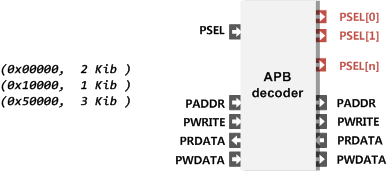

In [ ]:
showRtl(new Apb3Decoder(Apb3Config(16,32),List((0x00,20),
                                               (0x1000,1 KiB),
                                               (0x2000,1 KiB))))

#### ApbRouter   
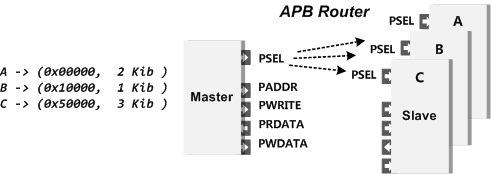

In [ ]:
showRtl(new Apb3Router(Apb3Config(16,32,3)))

In [ ]:
import spinal.lib.bus.amba3.apb._

class Top extends Component{    
    val din  =  slave(Apb3(Apb3Config(16,32)))
    val do1  = master(Apb3(Apb3Config( 8,32)))
    val do2  = master(Apb3(Apb3Config(12,32)))    
    val do3  = master(Apb3(Apb3Config(12,32)))      
    val do4  = master(Apb3(Apb3Config( 2,32)))
    
val mux = Apb3Decoder(master = din, 
                      slaves = List(do1 ->  (0x0000,  64 ),
                                    do2 ->  (0x1000,1 KiB),                                   
                                    do3 ->  (0x2000,3 KiB),                                   
                                    do4 ->  (0x3000,  32 )))
}
showRtl(new Top)                  

**注意**：  
对于apply多个匹配的情况，隐式转换需要制定参数名，否则隐式转换不成功
```scala
val mux = Apb3Decoder(Apb3Config(16,32),
                      List((0x00000,64),(0x10000,64)))

implicit def implicitTuple1(that:(Int, Int)):SizeMapping = SizeMapping(that._1,that._2)
```
会报错，原因是Apb3Decoder有多个模式匹配项(scala 隐式转换不能嵌套)，不知道匹配哪一个，隐式转换不成功
```scala
object Apb3Decoder{
  def apply(inputConfig: Apb3Config, decodings: Seq[SizeMapping]): Apb3Decoder={...}
  def apply(master: Apb3, slaves: Seq[(Apb3, SizeMapping)]): Apb3Decoder = {...}
}
```
正确的做法是，指定参数名（给编译器信息）

```scala
val mux = Apb3Decoder(inputConfig = Apb3Config(16,32),
                      decodings = List((0x00000,64),(0x10000,64)))
```

**对于只有一个apply的模式匹配，可以省略参数名**

### AXI crossBar
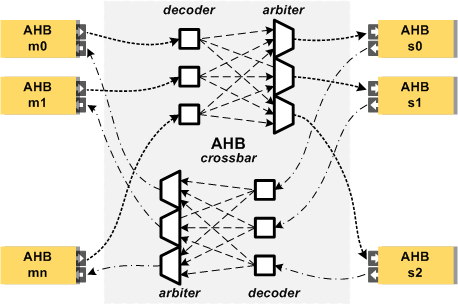

In [ ]:
import spinal.lib.bus.amba4.axi._ 

showRtl(Axi4SharedDecoder(
  axiConfig = Axi4Config(16,32,4),
  readDecodings = List((0x0000, 64    ),
                       (0x1000, 1 KiB ),
                       (0x2000, 3 KiB )),
  writeDecodings = List((0x1000, 3 KiB ),
                        (0x2000, 3 KiB )), 
  sharedDecodings = List((0x0000, 2 KiB),
                         (0x5000, 1 KiB) )
))

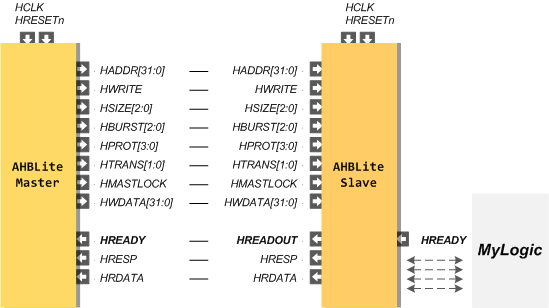

#### AhbToApb3 Bridge


In [ ]:
import spinal.lib.bus.amba3.apb._
import spinal.lib.bus.amba3.ahblite._

class Top(ahbConfig:AhbLite3Config, apbConfig:Apb3Config) extends Component{
    val ahb = slave(AhbLite3(ahbConfig))
    val apb = master(Apb3(apbConfig))
    val bridge = AhbLite3ToApb3Bridge(ahbConfig,apbConfig)
    ahb <> bridge.io.ahb
    apb <> bridge.io.apb
}

showRtl(new Top(AhbLite3Config(16,32),Apb3Config(16,32)))

In [ ]:
import spinal.lib.bus.amba3.apb._
import spinal.lib.bus.amba4.axi._

class Top(aw: Int,dw: Int,iw: Int) extends Component{
  val axi = slave(Axi4Shared(Axi4Config(aw,dw,iw)))
  val apb = master(Apb3(Apb3Config(aw,dw,iw)))
  val bridge = Axi4SharedToApb3Bridge(aw,dw,iw)
  axi <> bridge.io.axi
  apb <> bridge.io.apb
}

showRtl(new Top(20,32,2))

In [ ]:
import $ivy.`org.scalameta::scalameta:4.2.3`, scala.meta._

Downloaded https://repo1.maven.org/maven2/org/scalameta/scalameta_2.12/4.2.3/scalameta_2.12-4.2.3.pom.sha1
Downloaded https://repo1.maven.org/maven2/org/scalameta/scalameta_2.12/4.2.3/scalameta_2.12-4.2.3.pom
Downloaded https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.pom.sha1
Downloaded https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.pom
Downloaded https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.pom.sha1
Downloaded https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.pom
Downloaded https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.pom.sha1
Downloaded https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.pom
Downloaded https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.pom.sha1
Downloaded https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.

Downloaded https://repo1.maven.org/maven2/org/scalameta/fastparse-utils_2.12/1.0.1/fastparse-utils_2.12-1.0.1.jar
Downloaded https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar.sha1
Downloaded https://repo1.maven.org/maven2/org/scalameta/fastparse-utils_2.12/1.0.1/fastparse-utils_2.12-1.0.1.jar.sha1
Downloaded https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar.sha1
Downloaded https://repo1.maven.org/maven2/com/thesamet/scalapb/lenses_2.12/0.9.0/lenses_2.12-0.9.0.jar
Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (1.59 %, 8226 / 516657)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (1.35 %, 64995 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (1.24 %, 65536 / 5275144)
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (0.95 %, 7738 / 812559)
https

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (21.46 %, 174337 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (7.84 %, 376971 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (5.19 %, 97764 / 1885118)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (5.04 %, 26049 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (3.42 %, 180564 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (2.81 %, 103281 / 3675584)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (23.47 %, 190721 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (8.41 %, 404391 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/sc

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (31.90 %, 259186 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (14.84 %, 713438 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (8.23 %, 42501 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (5.92 %, 111559 / 1885118)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (3.79 %, 199707 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (3.04 %, 111558 / 3675584)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (31.90 %, 259186 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (15.29 %, 735170 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (31.90 %, 259186 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (21.78 %, 1046976 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (8.23 %, 42501 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (5.92 %, 111559 / 1885118)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (4.72 %, 248859 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (4.37 %, 160710 / 3675584)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (31.90 %, 259186 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (22.35 %, 1074396 / 4806616)
https://repo1.maven.org/maven2/org/scala-la

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (39.98 %, 324892 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (28.44 %, 1367229 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (8.49 %, 43872 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (7.83 %, 413209 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (6.79 %, 127943 / 1885118)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (5.34 %, 196407 / 3675584)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (42.00 %, 341276 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (29.30 %, 1408274 / 4806616)
https://repo1.maven.org/maven2/org/scala-la

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (76.70 %, 623243 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (34.59 %, 1662651 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (11.15 %, 57582 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (8.77 %, 462531 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (7.50 %, 275738 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (6.79 %, 127943 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (79.06 %, 642386 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (35.79 %, 1720080 / 4806616)
https://repo1.maven.org/maven2/org/scala-l

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (82.43 %, 669806 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (42.33 %, 2034645 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (17.78 %, 91857 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (11.05 %, 582907 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (8.53 %, 160711 / 1885118)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (7.95 %, 292122 / 3675584)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (82.43 %, 669806 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (42.67 %, 2051029 / 4806616)
https://repo1.maven.org/maven2/org/scala-

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (90.84 %, 738101 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (45.98 %, 2209861 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (20.96 %, 108309 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (14.53 %, 766400 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (9.06 %, 333167 / 3675584)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (90.84 %, 738101 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (46.54 %, 2237111 / 4806616)
https://repo1.maven.org/maven2/org/scal

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (95.57 %, 776557 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (51.84 %, 2491828 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (22.02 %, 113793 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (18.52 %, 977143 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (9.28 %, 341274 / 3675584)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (95.57 %, 776557 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (52.30 %, 2513730 / 4806616)
https://repo1.maven.org/maven2/org/scal

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (95.57 %, 776557 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (59.41 %, 2855375 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (22.02 %, 113793 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (19.09 %, 1007152 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (10.41 %, 382489 / 3675584)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/common_2.12/4.2.3/common_2.12-4.2.3.jar (95.57 %, 776557 / 812559)
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (60.15 %, 2891072 / 4806616)
https://repo1.maven.org/maven2/org/sc

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (63.56 %, 3055082 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (24.96 %, 1316539 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (22.29 %, 115164 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (11.89 %, 437159 / 3675584)
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (11.82 %, 114148 / 965660)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (64.47 %, 3098886 / 4806616)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (25.94 %, 1368450 / 5275144)
https://repo1.maven.org/ma

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (71.59 %, 3441041 / 4806616)
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (29.95 %, 289194 / 965660)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (29.62 %, 1562639 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (24.94 %, 128874 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (15.17 %, 557535 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (72.50 %, 3484845 / 4806616)
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (30.23 %, 291953 / 965660)
https://repo1.maven.org/maven2/or

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (79.50 %, 3821482 / 4806616)
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (38.45 %, 371284 / 965660)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (36.37 %, 1918419 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (19.41 %, 713438 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (79.50 %, 3821482 / 4806616)
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (38.45 %, 371284 / 965660)
https://repo1.maven.org/maven2/or

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (85.77 %, 4122592 / 4806616)
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (43.84 %, 423365 / 965660)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (38.65 %, 2038625 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (22.02 %, 809323 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (85.94 %, 4130869 / 4806616)
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (44.68 %, 431472 / 965660)
https://repo1.maven.org/maven2/or

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (92.66 %, 4453881 / 4806616)
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (59.68 %, 576339 / 965660)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (38.65 %, 2038625 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (22.46 %, 825707 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (93.46 %, 4492167 / 4806616)
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (59.68 %, 576339 / 965660)
https://repo1.maven.org/maven2/or

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (99.16 %, 4766027 / 4806616)
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (78.10 %, 754144 / 965660)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (38.70 %, 2041384 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (23.36 %, 858475 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/trees_2.12/4.2.3/trees_2.12-4.2.3.jar (99.16 %, 4766027 / 4806616)
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (82.92 %, 800707 / 965660)
https://repo1.maven.org/maven2/or

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (87.44 %, 844341 / 965660)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (38.80 %, 2046902 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (23.88 %, 877788 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0.jar (10.05 %, 209863 / 2087820)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (88.58 %, 855377 / 965660)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (39.11 %, 2063286 / 5275144

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (91.69 %, 885386 / 965660)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (41.55 %, 2191939 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (23.88 %, 877788 / 3675584)
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0.jar (22.90 %, 478035 / 2087820)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar (91.69 %, 885386 / 965660)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (42.02 %, 2216600 / 5275144

Downloaded https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3.jar
Downloaded https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0.jar.sha1
Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (45.49 %, 2399753 / 5275144)
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0.jar (36.52 %, 762421 / 2087820)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (26.86 %, 987298 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (3.11 %, 10497 / 337946)

Still downloading:
https:/

Still downloading:
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0.jar (50.29 %, 1049906 / 2087820)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (47.88 %, 2525647 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (29.99 %, 1102156 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0.jar (51.47 %, 1074567 / 2087820)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.j

Still downloading:
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0.jar (63.78 %, 1331533 / 2087820)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (51.72 %, 2728453 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (31.18 %, 1145960 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0.jar (64.83 %, 1353605 / 2087820)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.j

Still downloading:
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0.jar (74.27 %, 1550553 / 2087820)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (53.80 %, 2837793 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (31.70 %, 1165103 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0.jar (74.66 %, 1558830 / 2087820)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.j

Still downloading:
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0.jar (87.90 %, 1835279 / 2087820)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (54.83 %, 2892293 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0.jar (88.69 %, 1851663 / 2087820)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.j

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (55.09 %, 2905918 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)
https://repo1.maven.org/maven2/org/scalameta/scalameta_2.12/4.2.3/scalameta_2.12-4.2.3.jar (6.46 %, 48613 / 752563)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (55.09 %, 2905918 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://r

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (60.01 %, 3165643 / 5275144)
https://repo1.maven.org/maven2/org/scalameta/scalameta_2.12/4.2.3/scalameta_2.12-4.2.3.jar (48.63 %, 365937 / 752563)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (60.27 %, 3179268 / 5275144)
https://repo1.maven.org/maven2/org/scalameta/scalameta_2.12/4.2.3/scalameta_2.12-4.2.3.jar (56.99 %, 428884 / 752563)
https://re

Downloaded https://repo1.maven.org/maven2/org/scalameta/scalameta_2.12/4.2.3/scalameta_2.12-4.2.3.jar
Downloaded https://repo1.maven.org/maven2/org/scalameta/fastparse-utils_2.12/1.0.1/fastparse-utils_2.12-1.0.1-sources.jar
Downloaded https://repo1.maven.org/maven2/org/scalameta/fastparse-utils_2.12/1.0.1/fastparse-utils_2.12-1.0.1-sources.jar.sha1
Downloaded https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9-sources.jar.sha1
Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (61.31 %, 3234108 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scal

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (66.75 %, 3521253 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9-sources.jar (24.45 %, 251079 / 1026994)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (67.48 %, 3559539 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 367558

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (68.57 %, 3616968 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9-sources.jar (44.16 %, 453545 / 1026994)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (68.78 %, 3628004 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9-sources.jar (45.76 %, 469929 /

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9-sources.jar (72.37 %, 743279 / 1026994)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (70.49 %, 3718371 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9-sources.jar (75.56 %, 776047 / 1026994)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (71.11 %, 3751139 /

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (73.71 %, 3888069 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (0.70 %, 74484 / 10654847)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (73.71 %, 3888069 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
http

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (78.22 %, 4126062 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (3.37 %, 359210 / 10654847)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (78.79 %, 4156241 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
htt

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (80.45 %, 4243849 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (5.50 %, 586507 / 10654847)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (80.76 %, 4260233 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
htt

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (82.84 %, 4369743 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (8.20 %, 873992 / 10654847)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (82.94 %, 4375261 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
htt

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (82.99 %, 4378020 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (11.13 %, 1185798 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (82.99 %, 4378020 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
h

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (14.42 %, 1536060 / 10654847)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
h

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (18.65 %, 1987555 / 10654847)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
h

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (22.27 %, 2373344 / 10654847)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
h

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (26.70 %, 2844322 / 10654847)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
h

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (30.16 %, 3213727 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
h

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (33.58 %, 3577614 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (33.94 %, 3615900 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (37.02 %, 3944090 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (37.20 %, 3963233 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (40.36 %, 4299870 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (40.59 %, 4324531 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (43.74 %, 4660828 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (44.03 %, 4691007 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (47.21 %, 5030063 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (47.52 %, 5063001 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (50.62 %, 5393950 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (51.01 %, 5434995 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (55.19 %, 5880802 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (55.55 %, 5919088 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (58.89 %, 6274698 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (59.10 %, 6296600 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (61.89 %, 6594611 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (62.07 %, 6613924 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (65.26 %, 6953150 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (65.57 %, 6985918 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (68.52 %, 7300483 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (68.85 %, 7336010 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (71.98 %, 7669718 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (72.39 %, 7713352 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (76.06 %, 8104319 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (76.27 %, 8126221 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (80.15 %, 8539430 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (80.53 %, 8580475 / 10654847

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (83.38 %, 8884004 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (83.61 %, 8908665 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (87.03 %, 9272722 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (87.44 %, 9316696 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (91.01 %, 9696627 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (91.32 %, 9729565 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (94.34 %, 10052237 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (94.68 %, 10087764 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 52751

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (97.71 %, 10410606 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9.jar (98.09 %, 10451651 / 10654847)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 52751

Downloaded https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9-sources.jar
Downloaded https://repo1.maven.org/maven2/com/thesamet/scalapb/lenses_2.12/0.9.0/lenses_2.12-0.9.0-sources.jar
Downloaded https://repo1.maven.org/maven2/com/thesamet/scalapb/lenses_2.12/0.9.0/lenses_2.12-0.9.0-sources.jar.sha1
Downloaded https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9-sources.jar.sha1
Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/parsers_2.12/4.2.3/parsers_2.12-4.2.3-sources.jar (16.60 %, 7739 / 46618)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.ja

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/com/google/protobuf/protobuf-java/3.7.1/protobuf-java-3.7.1-sources.jar (20.12 %, 141738 / 704505)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/com/google/protobuf/protobuf-java/3.7.1/protobuf-java-3.7.1-sources.jar (64.01 %, 450955 / 704505)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/com/google/protobuf/protobuf-java/3.7.1/protobuf-java-3.7.1-sources.jar (69.84 %, 492

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.9.0-sources.jar (24.66 %, 64997 / 263607)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/com/thesamet/scalapb/scalapb-runtime_2.12/0.9.0/scalapb-runtime_2.12-0.

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9-sources.jar (13.13 %, 81920 / 623735)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9-sources.jar (76.42 %, 476637 / 623735)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9-sources.jar (81.70 %, 509575 / 

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/com/google/protobuf/protobuf-java/3.7.1/protobuf-java-3.7.1.jar (14.36 %, 204515 / 1424223)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
ht

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/com/google/protobuf/protobuf-java/3.7.1/protobuf-java-3.7.1.jar (42.20 %, 601000 / 1424223)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/com/google/protobuf/protobuf-java/3.7.1/protobuf-java-3.7.1.jar (44.12 %, 628420 / 1424223)


Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/com/google/protobuf/protobuf-java/3.7.1/protobuf-java-3.7.1.jar (66.39 %, 945574 / 1424223)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/com/google/protobuf/protobuf-java/3.7.1/protobuf-java-3.7.1.jar (68.12 %, 970235 / 1424223)


Still downloading:
https://repo1.maven.org/maven2/com/google/protobuf/protobuf-java/3.7.1/protobuf-java-3.7.1.jar (85.22 %, 1213746 / 1424223)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/com/google/protobuf/protobuf-java/3.7.1/protobuf-java-3.7.1.jar (88.49 %, 1260309 / 1424223)
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scala-lang/modules/scala-xml_2.12/1.0.6/scala-xml_2.12-1.0.6.jar (23.83 %, 130533 / 547860)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/modules/scala-xml_2.12/1.0.6/scala-xml_2.12-1.0.6.jar (74.32 %, 407152 / 547860)
https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.12.9/scala-reflect-2.12.9.jar (32.29 %, 1187005 / 3675584)
https://repo1.maven.org/maven2/org/scala-lang/scalap/2.12.9/scalap-2.12.9.jar (26.80 %, 138471 / 516657)
https://repo1.maven.org/maven2/org/scalameta/fastparse_2.12/1.0.1/fastparse_2.12-1.0.1.jar (14.38 %, 48613 / 337946)
https://repo1.maven.org/maven2/org/scala-lang/scala-compiler/2.12.9/scala-compiler-2.12.9-sources.jar (10.42 %, 196408 / 1885118)

Still downloading:
https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.9/scala-library-2.12.9.jar (83.36 %, 4397163 / 5275144)
https://repo1.maven.org/maven2/org/scala-lang/modules/scala-xml_2.12/1.0.6/scala-xml_2.12-1.0.6.jar (77.78 %, 426125 / 

In [10]:
printf("hell %d",32)

hell 32